# Pymaceuticals Inc.
---

### According to our analysis, Capomulin performs just under the top performer Ramicane in the treatment of squamous cell carcinoma. Compared to the other treatments analyzed, Capomulin has the second lowest central tendency and spread, and has shown to reduce the tumor volume by about 16% over the course of 45 days in our recent study. From our observations in subject l509, however, we recommend discontinuing use after about 35 days.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import linregress

In [2]:
#Read csv files
mice = pd.read_csv('Resources/Mouse_metadata.csv')
results = pd.read_csv('Resources/study_results.csv')

#Combine the data (1893, 8)
dirty_mice_results = pd.merge(results, mice, how='left', on=['Mouse ID'])

In [3]:
#Before clean up count (249)
dirty_count = dirty_mice_results['Mouse ID'].nunique()

In [4]:
#Find duplicates in DataFrame
mice_search = dirty_mice_results[dirty_mice_results.duplicated(['Mouse ID', 'Timepoint'])]
mice_rescue = np.array(mice_search['Mouse ID'])
mice_rescue[0]

'g989'

In [5]:
#DataFrame for duplicate values
dirty_mice_results[dirty_mice_results['Mouse ID'] == 'g989']

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
107,g989,0,45.000000,0,Propriva,Female,21,26
137,g989,0,45.000000,0,Propriva,Female,21,26
329,g989,5,48.786801,0,Propriva,Female,21,26
360,g989,5,47.570392,0,Propriva,Female,21,26
620,g989,10,51.745156,0,Propriva,Female,21,26
681,g989,10,49.880528,0,Propriva,Female,21,26
815,g989,15,51.325852,1,Propriva,Female,21,26
869,g989,15,53.442020,0,Propriva,Female,21,26
950,g989,20,55.326122,1,Propriva,Female,21,26
1111,g989,20,54.657650,1,Propriva,Female,21,26


In [6]:
#DataFrame devoid of duplicate values
clean_mice_results = dirty_mice_results[dirty_mice_results['Mouse ID'] != 'g989']

In [7]:
#After clean up count (248)
clean_count = clean_mice_results['Mouse ID'].nunique()
clean_count

248

## Summary Statistics

In [8]:
#DataFrame for summary
drug_df = clean_mice_results.groupby('Drug Regimen')['Tumor Volume (mm3)']

#Statistical values of tumor per drug
drug_summary = pd.DataFrame({
    'Mean Tumor Volume': drug_df.mean(),
    'Median Tumor Volume': drug_df.median(),
    'Tumor Volume Variance': drug_df.var(),
    'Tumor Volume Std. Dev.': drug_df.std(),
    'Tumor Volume Std. Err.': drug_df.sem()
})

drug_summary

,Mean Tumor Volume,Median Tumor Volume,Tumor Volume Variance,Tumor Volume Std. Dev.,Tumor Volume Std. Err.
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


In [9]:
#Optional .agg
drug_df.agg(['mean', 'median', 'var', 'std', 'sem']).style.set_caption('Tumor Volume (mm3)')

,mean,median,var,std,sem
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


In [10]:
#Number of timepoints per drug
drug_time_df = clean_mice_results.groupby('Drug Regimen')['Timepoint'].count().sort_values(ascending=False)

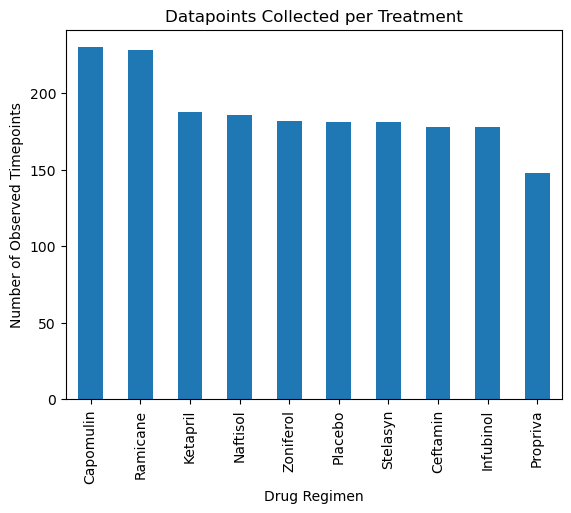

In [11]:
#Bar chart using Pandas
drug_time_df.plot.bar(title='Datapoints Collected per Treatment', ylabel = 'Number of Observed Timepoints');

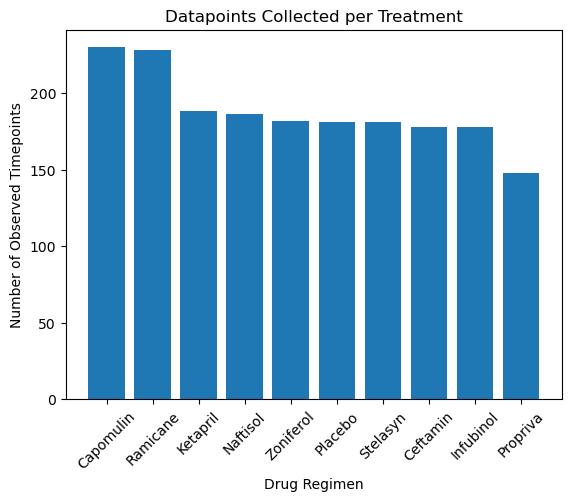

In [12]:
#Bar chart using matplotlib
plt.bar(drug_time_df.keys(), drug_time_df)
plt.xticks(rotation=45)
plt.title('Datapoints Collected per Treatment')
plt.xlabel('Drug Regimen')
plt.ylabel('Number of Observed Timepoints')
plt.show()

In [13]:
#DtaFrame of total male and female mice
sex_df = clean_mice_results.value_counts('Sex')

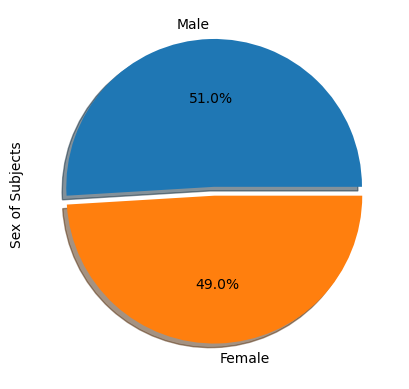

In [14]:
#Pie chart using Pandas
sex_df.plot.pie(autopct='%.1f%%', ylabel='Sex of Subjects', shadow=True, explode=[0.05, 0.01]);

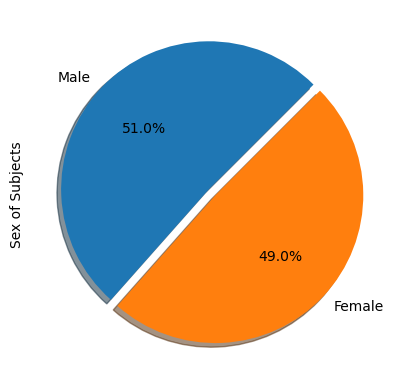

In [15]:
#Pie chart using matplotlib
plt.pie(sex_df, autopct='%.1f%%', labels=['Male', 'Female'], explode=(0.05, 0.01), shadow=True, startangle=45)
plt.ylabel('Sex of Subjects')
plt.show()

## Quartiles, Outliers, and Boxplots

In [16]:
#Preparation for outlier calculations
max_time = clean_mice_results.groupby('Mouse ID').max().Timepoint.reset_index()
max_tumor_df = max_time.merge(clean_mice_results, on=['Mouse ID','Timepoint'])

drugs = ['Capomulin', 'Ramicane', 'Infubinol', 'Ceftamin']

tumor_list = []

In [17]:
#Calculate outlier per target treatment
for drug in drugs:
    tumor_data = max_tumor_df[max_tumor_df['Drug Regimen'] == drug]['Tumor Volume (mm3)']
    tumor_list.append(tumor_data)

    iqr = tumor_data.quantile(.75) - tumor_data.quantile(.25)
    lower = tumor_data.quantile(.25) - (1.5 * iqr)
    upper = tumor_data.quantile(.75) + (1.5 * iqr)

    print(f"{drug}'s potential outliers: {tumor_data[(tumor_data < lower)|(tumor_data > upper)]}")


Capomulin's potential outliers: Series([], Name: Tumor Volume (mm3), dtype: float64)
Ramicane's potential outliers: Series([], Name: Tumor Volume (mm3), dtype: float64)
Infubinol's potential outliers: 31    36.321346
Name: Tumor Volume (mm3), dtype: float64
Ceftamin's potential outliers: Series([], Name: Tumor Volume (mm3), dtype: float64)


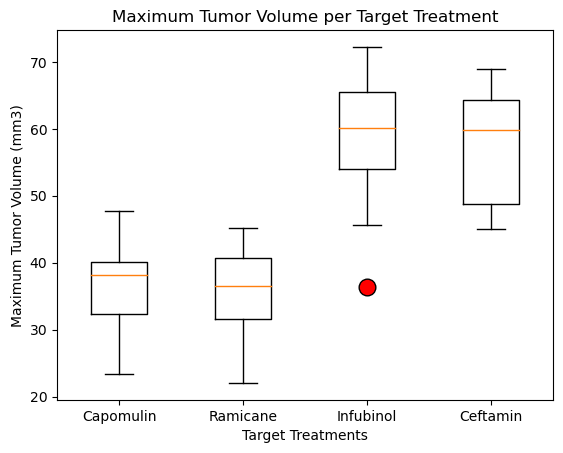

In [18]:
#Box and whisker plot of maximum tumor volumes across subjects
plt.boxplot(tumor_list, labels=drugs, flierprops={'markerfacecolor':'red','markersize':12})
plt.title('Maximum Tumor Volume per Target Treatment')
plt.xlabel('Target Treatments')
plt.ylabel('Maximum Tumor Volume (mm3)');

## Line and Scatter Plots

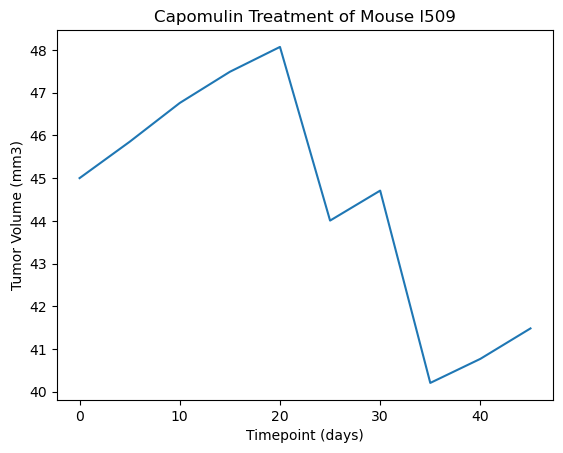

In [19]:
#DataFrame of the Capomulin treatment
capomulin_df = clean_mice_results[clean_mice_results['Drug Regimen'] == 'Capomulin']

#DataFrame of subject l509 on Capomulin
mouse_case_study = capomulin_df[capomulin_df['Mouse ID'] == 'l509']

#Tumor Volume belonging to subject l509 over Time 
plt.plot(mouse_case_study['Timepoint'], mouse_case_study['Tumor Volume (mm3)'])
plt.title('Capomulin Treatment of Mouse l509')
plt.xlabel('Timepoint (days)')
plt.ylabel('Tumor Volume (mm3)');

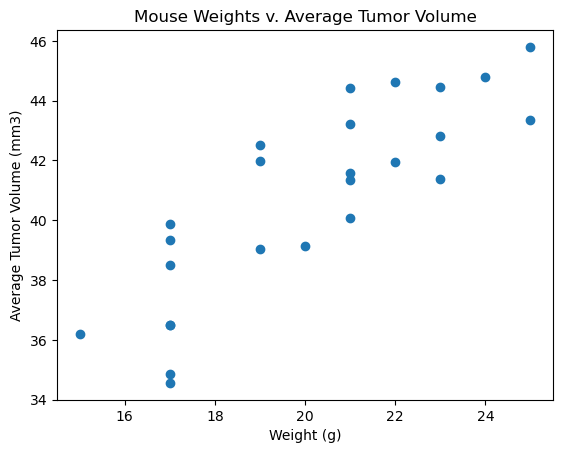

In [20]:
#Mean Weight and Tumor Volume per subject DataFrame
mouse_weight_tumor = clean_mice_results[clean_mice_results['Drug Regimen'] == 'Capomulin'].groupby('Mouse ID')[['Weight (g)','Tumor Volume (mm3)']].mean()

#Relationship between Weight and Tumor Volume scatter plot
plt.scatter(mouse_weight_tumor['Weight (g)'], mouse_weight_tumor['Tumor Volume (mm3)'])
plt.title('Mouse Weights v. Average Tumor Volume')
plt.xlabel('Weight (g)')
plt.ylabel('Average Tumor Volume (mm3)');

## Correlation and Regression

The correlation between mouse weight and the average tumor volume is 0.84


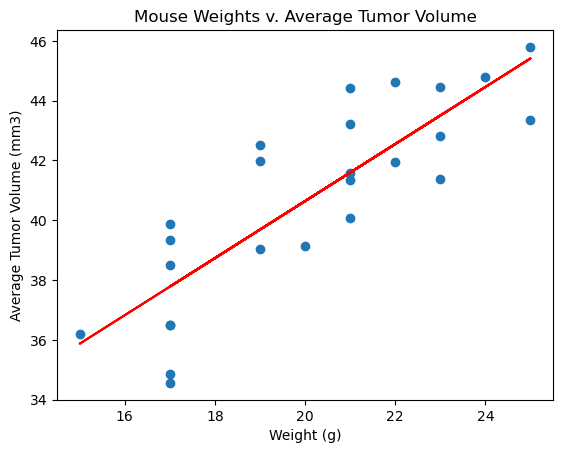

In [22]:
#Independent and dependent variables
x_axis = mouse_weight_tumor['Weight (g)']
y_axis = mouse_weight_tumor['Tumor Volume (mm3)']

#Calculating the Pearson Correlation Coefficient
correlation = st.pearsonr(x_axis, y_axis)
print(f'The correlation between mouse weight and the average tumor volume is {round(correlation[0], 2)}')

#Calculating the regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
best_fit_line = x_axis * slope + intercept

#Scatter plot
plt.scatter(x_axis, y_axis)
plt.plot(x_axis, best_fit_line, 'r-')
plt.title('Mouse Weights v. Average Tumor Volume')
plt.xlabel('Weight (g)')
plt.ylabel('Average Tumor Volume (mm3)');